In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

def plot_importances(columns,importances,figsize=None, ax=None):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    I.plot(kind='barh', figsize=figsize, legend=False, ax=ax, fontsize=14)

In [3]:
df = pd.read_csv("data/rent.csv")
features = ['bathrooms','bedrooms','longitude','latitude',
            'price']
df = df[features].copy()
df['price'] = np.log(df['price'])
df.head(5)

,bathrooms,bedrooms,longitude,latitude,price
0,1.5,3,-73.9425,40.7145,8.006368
1,1.0,2,-73.9667,40.7947,8.606119
2,1.0,1,-74.0018,40.7388,7.955074
3,1.0,1,-73.9677,40.7539,8.094073
4,1.0,4,-73.9493,40.8241,8.116716


# Built-in scikit importances

0.876759198211


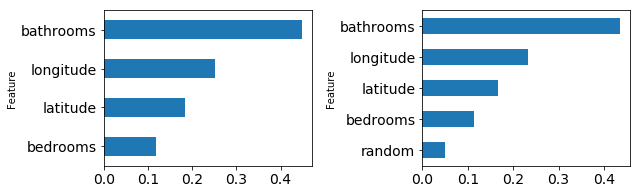

In [4]:
base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                oob_score=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,2.8))

X_train, y_train = df.drop('price',axis=1), df['price']
rf = clone(base_rf)
rf.fit(X_train, y_train)
print(rf.oob_score_)

plot_importances(X_train.columns,rf.feature_importances_, ax=axes[0])

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)
plot_importances(X_train2.columns,rf2.feature_importances_, ax=axes[1])

plt.tight_layout()
plt.show()

## Examine cost of dropping columns

In [5]:
from sklearn.base import clone

# max_features=n_features for regressors but sqrt for classifiers

def regressor_dropping_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.fit(X_train, y_train)
    oob = rf_.oob_score_
    print(f"oob R^2 score is {oob}")
    imp = []
    for col in X_train.columns:
        X = X_train.copy().drop(col, axis=1)
        rf_ = clone(rf)
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        print(f"{col:10s}: R^2 score {oob:5.4f} - {o:5.4f} = {oob - o:5.4f}")
        imp.append(oob - o)
    return np.array(imp)

oob R^2 score is 0.8775214604519737
bathrooms : R^2 score 0.8775 - 0.8434 = 0.0341
bedrooms  : R^2 score 0.8775 - 0.7927 = 0.0848
longitude : R^2 score 0.8775 - 0.7435 = 0.1340
latitude  : R^2 score 0.8775 - 0.7504 = 0.1272
oob R^2 score is 0.8588242695125652
bathrooms : R^2 score 0.8588 - 0.8214 = 0.0374
bedrooms  : R^2 score 0.8588 - 0.7548 = 0.1040
longitude : R^2 score 0.8588 - 0.6906 = 0.1682
latitude  : R^2 score 0.8588 - 0.6956 = 0.1633
random    : R^2 score 0.8588 - 0.8775 = -0.0187


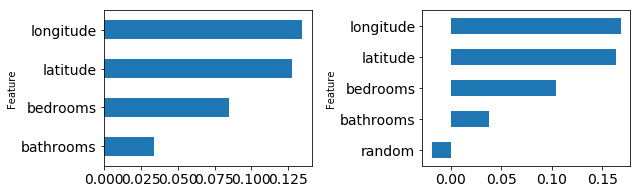

In [6]:
base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                oob_score=True,
                                random_state = 999) # same boostrapping samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,2.8))

X_train, y_train = df.drop('price',axis=1), df['price']
rf = clone(base_rf)

plot_importances(X_train.columns, 
                 regressor_dropping_importances(rf, X_train, y_train), ax=axes[0])

X_train, y_train = df.drop('price',axis=1), df['price']
X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
plot_importances(X_train2.columns,
                 regressor_dropping_importances(rf2, X_train2, y_train), ax=axes[1])

plt.tight_layout()
plt.show()

# Roll your own OOB R^2 score

In [10]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.metrics import r2_score
import warnings

# TODO: add arg for subsample size to compute oob score

def oob_regression_r2_score(rf, X_train, y_train):
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions
    
    oob_score = r2_score(y, predictions)
    return oob_score

# Permutation importance

In [8]:
def regression_permutation_importances(rf, X_train, y_train):
    rf.fit(X_train, y_train)
    oob = rf.oob_score_
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        o = oob_regression_r2_score(rf, X_train, y_train)
        X_train[col] = save
        print(f"{col:10s}: r2 score {oob:5.4f} - {o:5.4f} = {oob - o:5.4f}")
        imp.append(oob - o)
    return np.array(imp)

bathrooms : r2 score 0.8775 - 0.4559 = 0.4216
bedrooms  : r2 score 0.8775 - 0.3808 = 0.4967
longitude : r2 score 0.8775 - 0.3116 = 0.5659
latitude  : r2 score 0.8775 - 0.3852 = 0.4923
bathrooms : r2 score 0.8620 - 0.4526 = 0.4093
bedrooms  : r2 score 0.8620 - 0.3816 = 0.4804
longitude : r2 score 0.8620 - 0.3626 = 0.4994
latitude  : r2 score 0.8620 - 0.4481 = 0.4139
random    : r2 score 0.8620 - 0.8615 = 0.0005


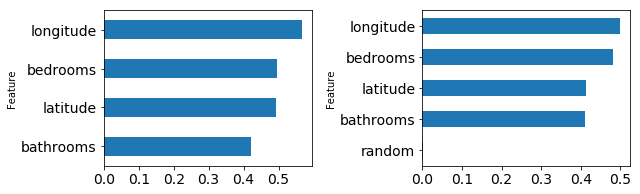

In [9]:
X_train, y_train = df.drop('price',axis=1), df['price']

base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                max_features=len(X_train.columns),
                                oob_score=True,
                                random_state = 999) # same boostrapping samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,2.8))

rf = clone(base_rf)
rf.fit(X_train, y_train)
plot_importances(X_train.columns,
                 regression_permutation_importances(rf, X_train, y_train), ax=axes[0])

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)

plot_importances(X_train2.columns,
                 regression_permutation_importances(rf2, X_train2, y_train), ax=axes[1])

plt.tight_layout()
plt.show()